# CS5950J Course Project

This project recaps and systematises work that has been done in the exercise notebooks: if you have worked through the notebooks, little extra work is required.  The aim of the project is to give you the experience of trying to develop a neural network classifier (or regressor), involving setting up a model, optimising the amount of regularisation, investigating its performance, and devising a new model. 

You should do your work in this notebook, filling in the sections below. To do the work, you may re-use code from ***any of the lab-session sheets provided so far***. (In fact, you should be able to do nearly the entire project using code taken from previous lab sessions.) 

Please complete this workbook and submit it on Moodle, with all outputs (numbers and graphs) visible and included. (I do not want to have to evaluate your notebook!) 

Ideally, do not re-use cells for multiple computations, accumulating the results by hand: have a a separate cell for each computation, so that I can look through the whole notebook and see what you have done, in sequence. This makes it much easier for me to understand what has happened if something has gone wrong.

This project has **10%** of the marks of the course.

The submission deadline is Wednesday 30th June at 4pm (on Moodle of course). 

Please write your student number **100943568**:     
so that I have an identifier of which worksheet I am marking, to prevent any confusion! (I have to download your notebooks before marking them, so I don't want to accidentally give credit for your notebook to somebody else...) 

## Set up dataset

You may choose any of the datasets included with Pytorch, or used in the course so far (including, for example, the percolation data). (It is a free country and you may use any other data you wish.)

A safe choice would be either the MNIST data or the MNIST-fashion data, which is a drop-in replacement for MNIST (same size data format, same number of classes, same number of training and test examples). 

A more interesting choice would be CIFAR-10

In setting up the data, you should set up a training set and a test set. The test set should be large enough to give a reasonably accurate assessment of the error-rate (or loss) of your models: preferably at least 10,000 examples.

For the learning curve experiment (below), you will need to construct training sets of different sizes, with the largest at least 10 times the smallest. For the MNIST data, for example, your smallest training set might be 500, with sizes 500, 1000, 2000, 4000, 8000, 16000, 32000, and perhaps 60000 if you have time. (You get no extra marks for doing very long experiments.) 

## Set up model 

Set up a Pytorch model (you may find it helpful to keep it simple and fast to train). Train on an intermediate-sized dataset (if you are using MNIST, say 2000 or 4000). 


Plot the loss and error rate as a function of training epochs. 


###  1.  Assessment of initial model:    ***12 marks***

Ensure that your model is complex enough to *overfit* the training data: that is the loss/error-rate on the training set should be below your target loss/error-rate, and the loss/error-rate on the validation set should be higher than this (preferably higher than your target error-rate). 

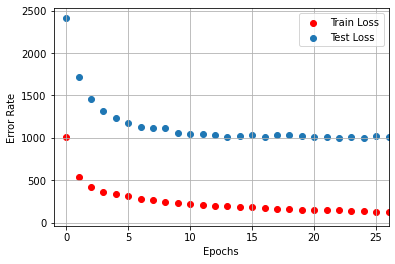

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
from torchvision import transforms
import torch.optim as optim 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm  # colormaps
%matplotlib inline

transform_list = transforms.Compose([ transforms.ToTensor(), transforms.Normalize(mean=[0.0], std=[1.0,]) ] )
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform_list)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform_list)

mnist_trainset_small =  [ mnist_trainset[i] for i in range(0,3000) ] 
mnist_testset_small =  [ mnist_trainset[i] for i in range(0,2000) ] 
class NN1( nn.Module ):   
    def __init__(self): 
        super(NN1, self).__init__()
        self.layers = nn.Sequential( 
            nn.Flatten(), 
            nn.Linear(28*28,200),
            nn.Linear(200, 100), 
            nn.Linear(100, 10))  
               
    def forward( self, x ): # computes the forward pass 
        x = self.layers( x )
        return x


trainloader = torch.utils.data.DataLoader( mnist_trainset_small, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader( mnist_testset, batch_size=32, shuffle=True)
nn1 = NN1()
optimizer1 = optim.RMSprop( nn1.parameters(), lr=0.0001 )
loss_function = nn.CrossEntropyLoss() 

epoch_no = []
loss_test = []
loss_train = []
for epoch in range(40): # number of times to loop over the dataset
    current_loss = 0.0 
    n_mini_batches = 0
    error_train = 0
    
    for i, mini_batch in enumerate( trainloader, 0 ):
        images, labels = mini_batch
        optimizer1.zero_grad()
        
        outputs = nn1(images)
        _, predicted = torch.max( outputs, dim=1)
        error_train += (predicted != labels).sum().item()
        loss = loss_function ( outputs, labels )
        loss.backward() # does the backward pass and computes all gradients
        optimizer1.step() # does one optimisation step     
        n_mini_batches += 1 
        current_loss += loss.item()
    loss_train.append(error_train)
    
    correct = 0 
    total = 0 
    loss_individual = 0
    with torch.no_grad():
        for data in testloader: 
            images, labels = data
            outputs = nn1(images)
            _, predicted = torch.max( outputs, dim=1)
            total += labels.size(0) # the number of labels, which is just the size of the batch 
            correct += (predicted == labels).sum().item()
            loss_individual += (predicted != labels).sum().item()
    epoch_no.append(epoch) 
    loss_test.append(loss_individual)
plt.scatter(epoch_no, loss_train, color='r')
plt.scatter(epoch_no, loss_test)
plt.xlim([-1,26])
plt.legend(('Train Loss','Test Loss'))
plt.xlabel('Epochs')
plt.ylabel('Error Rate')
plt.grid()

### 2.  Regularisation experiment:  ***12 marks***

Now select a type of regularisation (which may be L2, or dropout) and train your initial model with different amounts of regularisation. 

For L2 regularisation, compare 0 regularisation with very small amounts of regularisation -- try 0.0001, 0.001, 0.01, and see for what level of L2 regularisation there starts to be an effect. 

A small amount of regularisation may improve the validation set performance of your overfitted model; too much regularisation may make performance on the validation set worse. 

Train your model multiple times, applying different amounts of regularisation, and plot a graph showing the effect of different amounts of regularisation. 

Plot the amount of regularisation along the x axis, and the validation set performance (loss/error-rate) on the y axis.  How does regularisation affect the performance of your initial network, and what is the optimal amount? 

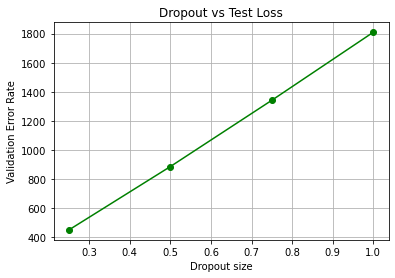

In [2]:
trainloader = torch.utils.data.DataLoader( mnist_trainset_small, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader( mnist_testset_small, batch_size=32, shuffle=True)
dropout_d = [0.25, 0.50, 0.75, 1.00]
loss_test_d = []
for dropout_value in dropout_d:
    class NN1( nn.Module ):   
        def __init__(self): 
            super(NN1, self).__init__()
            self.layers = nn.Sequential( 
                nn.Flatten(), 
                nn.Linear(28*28,200),
                nn.Linear(200, 100), 
                nn.Linear(100, 10),
                nn.Dropout(dropout_value))

        def forward( self, x ): # computes the forward pass ... this one is particularly simple
            x = self.layers( x )
            return x
    nn1 = NN1()  
    optimizer1 = optim.RMSprop( nn1.parameters(), lr=0.0001 )
    for epoch in range(40): # number of times to loop over the dataset
        current_loss = 0.0 
        n_mini_batches = 0
        error_train = 0

        for i, mini_batch in enumerate( trainloader, 0 ):
            images, labels = mini_batch
            optimizer1.zero_grad()

            outputs = nn1(images)
            _, predicted = torch.max( outputs, dim=1)
            error_train += (predicted != labels).sum().item()
            loss = loss_function ( outputs, labels )
            loss.backward() # does the backward pass and computes all gradients
            optimizer1.step() # does one optimisation step     
            n_mini_batches += 1 
            current_loss += loss.item()

    correct = 0 
    total = 0 
    loss_individual = 0
    with torch.no_grad():  # we do not neet to compute the gradients when making predictions on the validation set
        for data in testloader: 
            images, labels = data
            outputs = nn1(images)
            _, predicted = torch.max( outputs, dim=1)
            total += labels.size(0) # the number of labels, which is just the size of the batch 
            correct += (predicted == labels).sum().item()
            loss_individual += (predicted != labels).sum().item()
    loss_test_d.append(loss_individual)
plt.plot(dropout_d, loss_test_d,'go-')
plt.title(('Dropout vs Test Loss')) 
plt.xlabel('Dropout size')
plt.ylabel('Validation Error Rate')
plt.grid()


With using the Dropout Regularisation, we see that the error rate increases for the validation set as shown from the graph as the value of dropout increases - we make more neurons shut off. The idea value of dropout seems to be between 0.5 to 0.75 in this case, as the validation set error rate seems t steeps up more after that. At Dropout value 1, the error rate is the highest as all the neurons are shut.


### 3.  Learning curve experiment:  ***12 marks***

Now train your model (with the amount of regularisation you selected) on different amounts of training data. 

Plot the performance (loss/error-rate) of the model on the validation set against the size of the training set. 
This is typically best done on a log-log plot. 

Describe the approximate relationship between the training set size and loss / error-rate.  Does the network performance appear to improve as some power of the amount of data in the training set?  If so, by what power ? 

For example, a very good rate of improvement is for error-rate to be proportional to $\dfrac{1}{\sqrt{n}}$ where $n$ is the training set size.  For your model, the rate of improvement of validation error with training set size may not be as fast as this (or it may, who knows?)  The aim of this exercise is to find out what it actually is. 

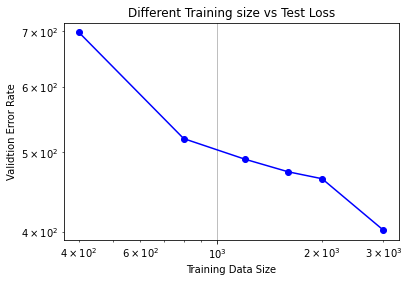

In [3]:
mnist_trainset_400 =  [ mnist_trainset[i] for i in range(0,400) ] 
mnist_trainset_800 =  [ mnist_trainset[i] for i in range(0,800) ] 
mnist_trainset_1200 =  [ mnist_trainset[i] for i in range(0,1200) ] 
mnist_trainset_1600 =  [ mnist_trainset[i] for i in range(0,1600) ] 
mnist_trainset_2000 =  [ mnist_trainset[i] for i in range(0,2000) ] 
mnist_trainset_3000 =  [ mnist_trainset[i] for i in range(0,3000) ] 
mnist_trainset_list = [mnist_trainset_400,mnist_trainset_800, mnist_trainset_1200,mnist_trainset_1600, mnist_trainset_2000, mnist_trainset_3000]
mnist_trainset_list_size = [len(mnist_trainset_400),len(mnist_trainset_800),len(mnist_trainset_1200),len(mnist_trainset_1600),len(mnist_trainset_2000),len(mnist_trainset_3000)]
mnist_testset_3000 =  [ mnist_testset[i] for i in range(0,3000) ]
loss_test_q3 = []

for i in range(0,len(mnist_trainset_list_size)):
    trainloader = torch.utils.data.DataLoader( mnist_trainset_list[i], batch_size=32, shuffle=True)
    testloader = torch.utils.data.DataLoader( mnist_testset_3000, batch_size=32, shuffle=True)

    dropout_q3 = [0]
    
    for dropout_value in dropout_q3:
        class NN1( nn.Module ):   
            def __init__(self): 
                super(NN1, self).__init__()
                self.layers = nn.Sequential( 
                    nn.Flatten(), 
                    nn.Linear(28*28,200),
                    nn.Linear(200, 100), 
                    nn.Linear(100, 10),
                    nn.Dropout(dropout_value))

            def forward( self, x ): # computes the forward pass ... this one is particularly simple
                x = self.layers( x )
                return x
        nn1 = NN1()    
        optimizer1 = optim.RMSprop( nn1.parameters(), lr=0.0001 )
        for epoch in range(40): # number of times to loop over the dataset
            current_loss = 0.0 
            n_mini_batches = 0
            error_train = 0

            for i, mini_batch in enumerate( trainloader, 0 ):
                images, labels = mini_batch
                optimizer1.zero_grad()

                outputs = nn1(images)
                _, predicted = torch.max( outputs, dim=1) 
                error_train += (predicted != labels).sum().item()
                loss = loss_function ( outputs, labels )
                loss.backward()
                optimizer1.step()     
                n_mini_batches += 1 
                current_loss += loss.item()

        correct = 0 
        total = 0 
        loss_individual = 0
        with torch.no_grad(): 
            for data in testloader: 
                images, labels = data
                outputs = nn1(images)
                _, predicted = torch.max( outputs, dim=1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                loss_individual += (predicted != labels).sum().item() 
    loss_test_q3.append(loss_individual)
plt.loglog(mnist_trainset_list_size, loss_test_q3,'bo-')
plt.title(('Different Training size vs Test Loss'))
plt.xlabel('Training Data Size')
plt.ylabel('Validtion Error Rate')
plt.grid()


We see that as the size of Training set data increases, the error rate on the validation set decreases. So this relation is inversely proportional of 1/root(n).


### 4. Second model:   *** 14 marks ***

Devise what you believe to be a better neural network architecture for the problem (e.g. for MNIST you might use a fully-connected network for your initial model, and then try a convolutional net for your second model).

Repeat sections 2 (regularisation experiment), and determine whether it has better validation set performance than the first model, for an intermediate size of training set (e.g. 2000 or 4000 for the MNIST data). 

Repeat section 3. Does your model have a different learning curve from the first? Plot the learning curves for the first and second model on the same graph, to compare them. Comment: is there a more rapid reduction of error-rate with training set size for your second model?  

In [7]:
#2nd Model : Convolution Network
class Cov_Net(nn.Module):   
    def __init__(self):
        super(Cov_Net, self).__init__()
            
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 5, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(5, 10, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(32 * 5, 25)
        self.fc2 = nn.Linear(25, 10)
        

    # Defining the forward pass    
    def forward(self, x):
        y = self.layer1(x)
        y = self.layer2(y)
        y = y.view(-1, 32*5)
        y = self.drop_out(y)
        y = self.fc1(y)
        y = self.fc2(y)
        return y

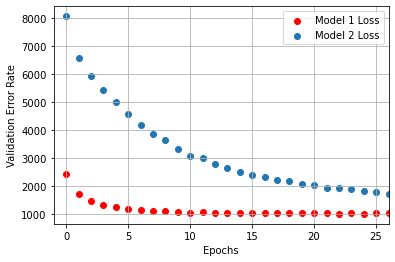

In [9]:

trainloader = torch.utils.data.DataLoader( mnist_trainset_small, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader( mnist_testset, batch_size=32, shuffle=True)
cov_net3 = Cov_Net()
optimizer1 = optim.RMSprop( cov_net3.parameters(), lr=0.0001 )
loss_function = nn.CrossEntropyLoss() 

epoch_no = []
loss_test_q1 = []
loss_train_r = []
for epoch in range(40): # number of times to loop over the dataset
    current_loss = 0.0 
    n_mini_batches = 0
    error_train = 0
    
    for i, mini_batch in enumerate( trainloader, 0 ):
        images, labels = mini_batch
        optimizer1.zero_grad()
        
        outputs = cov_net3(images)
        _, predicted = torch.max( outputs, dim=1)
        error_train += (predicted != labels).sum().item()
        loss = loss_function ( outputs, labels )
        loss.backward() # does the backward pass and computes all gradients
        optimizer1.step() # does one optimisation step     
        n_mini_batches += 1 
        current_loss += loss.item()
    loss_train_r.append(error_train)
    
    correct = 0 
    total = 0 
    loss_individual_q1 = 0
    with torch.no_grad():
        for data in testloader: 
            images, labels = data
            outputs = cov_net3(images)
            _, predicted = torch.max( outputs, dim=1)
            total += labels.size(0) # the number of labels, which is just the size of the batch 
            correct += (predicted == labels).sum().item()
            loss_individual_q1 += (predicted != labels).sum().item()
    epoch_no.append(epoch) 
    loss_test_q1.append(loss_individual_q1)
plt.scatter(epoch_no, loss_test, color='r')
plt.scatter(epoch_no, loss_test_q1)
plt.xlim([-1,26])
plt.legend(('Model 1 Loss','Model 2 Loss'))
plt.xlabel('Epochs')
plt.ylabel('Validation Error Rate')
plt.grid()

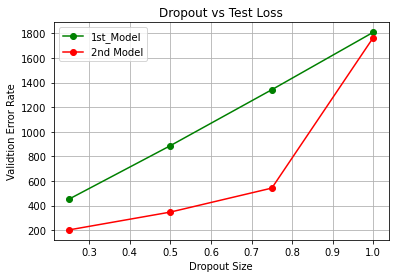

In [10]:
#Regularisation as Task 2
mnist_trainset_small =  [ mnist_trainset[i] for i in range(0,3000) ] 
mnist_testset_small =  [ mnist_testset[i] for i in range(0,2000) ] 
trainloader = torch.utils.data.DataLoader( mnist_trainset_small, batch_size=32, shuffle=True)
testloader = torch.utils.data.DataLoader( mnist_testset_small, batch_size=32, shuffle=True)

dropout_r = [0.25, 0.50, 0.75, 1.00]
loss_test_r = []
for dropout_value in dropout_r:
    class Cov_Net(nn.Module):   
        def __init__(self):
            super(Cov_Net, self).__init__()
            
            self.layer1 = nn.Sequential(
                nn.Conv2d(1, 5, kernel_size=5),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2))
            self.layer2 = nn.Sequential(
                nn.Conv2d(5, 10, kernel_size=5),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2))
            self.drop_out = nn.Dropout(dropout_value)
            self.fc1 = nn.Linear(32 * 5, 25)
            self.fc2 = nn.Linear(25, 10)


        # Defining the forward pass    
        def forward(self, x):
            y = self.layer1(x)
            y = self.layer2(y)
            y = y.view(-1, 32*5)
            y = self.drop_out(y)
            y = self.fc1(y)
            y = self.fc2(y)
            return y
    
    cov_net1 = Cov_Net()
    optimizer1 = optim.RMSprop( cov_net1.parameters(), lr=0.0001 )
    for epoch in range(40): # number of times to loop over the dataset
        current_loss = 0.0 
        n_mini_batches = 0
        error_train = 0

        for i, mini_batch in enumerate( trainloader, 0 ):
            images, labels = mini_batch
            optimizer1.zero_grad()

            outputs = cov_net1(images)
            _, predicted = torch.max( outputs, dim=1)
            error_train += (predicted != labels).sum().item()
            loss = loss_function ( outputs, labels )
            loss.backward() # does the backward pass and computes all gradients
            optimizer1.step() # does one optimisation step     
            n_mini_batches += 1 
            current_loss += loss.item()

    correct_r = 0 
    total = 0 
    loss_individual_r = 0
    with torch.no_grad(): 
        for data in testloader: 
            images, labels = data
            outputs = cov_net1(images)
            _, predicted = torch.max( outputs, dim=1)
            correct_r += (predicted == labels).sum().item()
            loss_individual_r += (predicted != labels).sum().item()
    loss_test_r.append(loss_individual_r)
plt.plot(dropout_d, loss_test_d,'go-')
plt.plot(dropout_r, loss_test_r,'ro-')
plt.legend(('1st_Model', '2nd Model'))
plt.title(('Dropout vs Test Loss'))
plt.xlabel('Dropout Size')
plt.ylabel('Validtion Error Rate')
plt.grid()

From the above graph we see that for the second model - the convolution network, the validation set error rate is lesser. The error values are lesser in general. So this performs better.


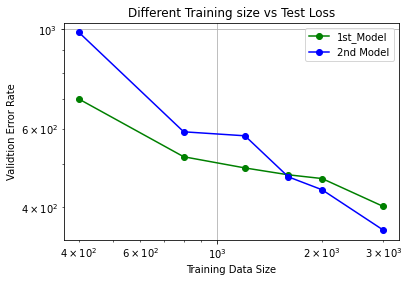

In [11]:
#Repeat Task 3 - Different size of Training Set data
loss_test_q4 = []
cov_net2 = Cov_Net() 
optimizer1 = optim.RMSprop( cov_net2.parameters(), lr=0.0001 )

for i in range(0,len(mnist_trainset_list_size)):
    trainloader = torch.utils.data.DataLoader( mnist_trainset_list[i], batch_size=32, shuffle=True)
    testloader = torch.utils.data.DataLoader( mnist_testset_3000, batch_size=32, shuffle=True)

    dropout_q4 = [0]
    
    for dropout_value in dropout_q4:
        class Cov_Net(nn.Module):   
            def __init__(self):
                super(Cov_Net, self).__init__()

                self.layer1 = nn.Sequential(
                    nn.Conv2d(1, 5, kernel_size=5),
                    nn.ReLU(),
                    nn.MaxPool2d(kernel_size=2))
                self.layer2 = nn.Sequential(
                    nn.Conv2d(5, 10, kernel_size=5),
                    nn.ReLU(),
                    nn.MaxPool2d(kernel_size=2))
                self.drop_out = nn.Dropout(dropout_value)
                self.fc1 = nn.Linear(32 * 5, 25)
                self.fc2 = nn.Linear(25, 10)


            # Defining the forward pass    
            def forward(self, x):
                y = self.layer1(x)
                y = self.layer2(y)
                y = y.view(-1, 32*5)
                y = self.drop_out(y)
                y = self.fc1(y)
                y = self.fc2(y)
                return y
        cov_net2 = Cov_Net()    
        optimizer1 = optim.RMSprop( cov_net2.parameters(), lr=0.0001 )
        for epoch in range(40):
            current_loss = 0.0 
            n_mini_batches = 0
            error_train = 0

            for i, mini_batch in enumerate( trainloader, 0 ):
                images, labels = mini_batch
                optimizer1.zero_grad()
                outputs = cov_net2(images)
                _, predicted = torch.max( outputs, dim=1)
                error_train += (predicted != labels).sum().item()
                loss = loss_function ( outputs, labels )
                loss.backward()
                optimizer1.step()     
                n_mini_batches += 1 
                current_loss += loss.item()

        correct = 0 
        total = 0 
        loss_individual_r = 0
        with torch.no_grad(): 
            for data in testloader: 
                images, labels = data
                outputs = cov_net2(images)
                _, predicted = torch.max( outputs, dim=1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                loss_individual_r += (predicted != labels).sum().item() 
        loss_test_q4.append(loss_individual_r)

plt.loglog(mnist_trainset_list_size, loss_test_q3,'go-')
plt.loglog(mnist_trainset_list_size, loss_test_q4,'bo-')
plt.title(('Different Training size vs Test Loss'))
plt.legend(('1st_Model', '2nd Model'))
plt.xlabel('Training Data Size')
plt.ylabel('Validtion Error Rate')
plt.grid()

As seen from the graph, the error rate for the second model on the validation set is going down faster with the increase in the Training size data. It is reducing more than the first model. There is a rapid reduction in the error rate for the second model.
